In [2]:
! pip install python-mnist pyarrow scipy matplotlib

In [2]:
from mnist import MNIST
import numpy as np
import json
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
num_classes = 10
num_directions = 4
proj_dim = num_directions + 1
dim = 28
num_images, img_size = 60000, 28 * 28
sample_size = num_images // 300

def plot_params(test_params):
    num_row = 2
    num_col = 5
    num = 10
    length = img_size + 1

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        img = test_params[i*length:(i+1)*length - 1]
        img = img.reshape((dim, dim))
        ax.imshow(img)
        
        ax.set_title('Class: {}'.format(i))
    plt.tight_layout()
    plt.show()

In [15]:
mndata = MNIST("../../mnist_rs/data")
images, labels = mndata.load_training()
images_by_label = []
for _ in range(len(set(labels))):
    images_by_label.append([])

for image, label in zip(images, labels):
    images_by_label[label].append(image)

training_set = np.array(images)
training_labels = np.array(labels)
training_set_by_label = [np.array(ary) for ary in images_by_label]

print(training_set_by_label[0].dtype)


int64


In [10]:
num_classes = 10
num_directions = 4
proj_dim = num_directions + 1
num_images, img_size = np.shape(training_set)
sample_size = num_images // 300

In [30]:
# Have some fun around matrix decomposition
# Compute directions as the SVD of the training data
sparse_training = sparse.csc_matrix(training_set.astype("float64"))
(u, s, vh) = sparse.linalg.svds(sparse_training, k=num_directions)

# By training label
directions_by_label = []
for class_set in training_set_by_label:
    sparse_by_label = sparse.csc_matrix(class_set.astype("float64"))
    (sparse_u, sparse_s, sparse_vh) = sparse.linalg.svds(sparse_by_label, k=num_directions)
    directions_by_label.append(sparse_vh)
directions_by_label = np.array(directions_by_label)
directions_trans = np.transpose(directions_by_label, (1,0,2))

directions = directions_trans.reshape((num_directions, -1))
directions = np.absolute(directions)


NameError: name 'directions' is not defined

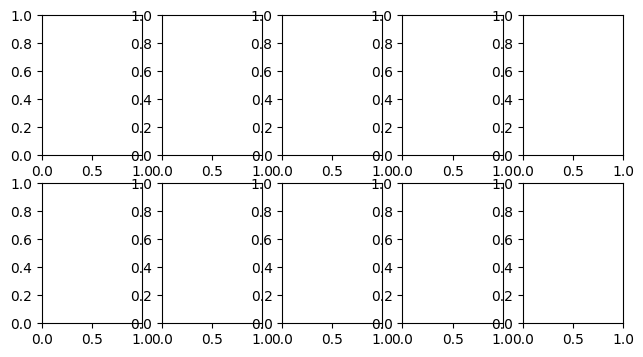

In [32]:
num_row = 2
num_col = 5
num = 10
dim = 28
length = dim * dim

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    img = directions[0,i*length:(i+1)*length]
    img = img.reshape((dim, dim))
    ax.imshow(img, cmap='gray')
    ax.set_title('Class: {}'.format(i))
plt.tight_layout()
plt.show()

In [40]:
rs = np.random.RandomState(42)
np.random.set_state(rs.get_state())
rng = np.random.default_rng()
param = rng.standard_normal(size=[num_classes * img_size], dtype='float64')

dir_shape = [num_directions, num_classes * img_size]
directions_noise = rng.standard_normal(size=dir_shape, dtype='float64') #+ np.ones(shape=dir_shape, dtype='float64')
directions = directions_noise # + directions
projection = np.concatenate([directions, np.expand_dims(param, 0)], axis=0)
# Because the feature vector is mostly sparse, we reshape our projection matrix
reshaped = projection.transpose().reshape([num_classes, img_size, -1])


sample_indices = np.random.choice(num_images, size=sample_size, replace=False)
samples = []
for index in sample_indices:
    samples.append((labels[index], images[index]))
    #if len(samples) == num_classes:
    #    break

sampled_labels, sampled_images = (np.array(ary) for ary in zip(*samples))
#projected = training_set[sample_indices, :] @ reshaped
projected = sampled_images @ reshaped

In [41]:
zeros = []
for i in range(img_size):
    zeroed_fea = True
    for image in sampled_images:
        zeroed_fea &= image[i] == 0
        if not zeroed_fea:
            break
    if zeroed_fea:
        zeros.append(i)

print(len(zeros) / img_size)

0.29591836734693877


In [33]:
num_row = 2
num_col = 5
num = 10
dim = 28
length = dim * dim

sampled = sampled_images[0]
print(sampled.shape)
squeezed = reshaped.squeeze()
print(squeezed.shape)
projected_img = squeezed * sampled
print(projected_img.shape)

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    #img = projection[0, i*length:(i+1)*length].reshape((-1))
    #img = sampled_images[0]
    img = projected_img[i,:]
    #img = projection[0, i*length:(i+1)*length].reshape((-1))
    img = img.reshape((dim, dim))
    ax.imshow(img, cmap='gray')
    ax.set_title('Class: {}'.format(i))
plt.tight_layout()
plt.show()

(784,)
(10, 784, 5)


ValueError: operands could not be broadcast together with shapes (10,784,5) (784,) 

In [18]:
for i in range(10):
    print(projected[:,i,:].reshape(-1).argmax(), sampled_labels[i])

8 5
8 0
15 4
13 1
8 9
8 2
19 1
15 3
12 1
11 4


In [34]:
polytopes = projected.transpose([1,0,2]).reshape([-1])
polytope_dim = num_classes * proj_dim
vertex_index = np.tile(np.arange(stop=polytope_dim, dtype="i"), len(samples)) // proj_dim
polytope_index = np.arange(stop=polytope_dim * len(samples), dtype="i") // polytope_dim
dim = np.tile(np.arange(stop=proj_dim, dtype="i"), len(samples) * num_classes)

with open("./labels.json", "w") as label_file:
    json.dump(sampled_labels.tolist(), label_file)

polytope_table = pa.table({"polytope": polytope_index, "vertex": vertex_index, "dim": dim, "value": polytopes})
pq.write_table(polytope_table, "mnist.parquet")
# inputs = [{"vertices" : points.tolist()} for points in polytopes]
# print(inputs[0])
# with open("mnist.json", "wt") as out_file:
#     json.dump(inputs, out_file, indent=2)

In [96]:
with open("states_out_iter2.jsonl", "rt") as states_file:
    states = [json.loads(line) for line in states_file]

In [126]:
states.sort(key=lambda x: x["accuracy"], reverse=True)
print(states[0]["minkowski_decomp"], states[0]["accuracy"])

proj_param = np.array(states[0]["param"]["data"])

proj_param = proj_param / proj_param[-1]

new_params = proj_param.reshape((-1, 1)) * projection
new_params = new_params.sum(axis=0)
 

[1, 8, 1, 8, 2, 1, 7, 8, 9, 2, 2, 7, 2, 1, 1, 7, 2, 7, 2, 8, 1, 7, 7, 2, 8, 6, 7, 5, 7, 2, 4, 1, 4, 4, 6, 1, 8, 8, 7, 1, 2, 4, 2, 2, 2, 1, 7, 2, 8, 4, 1, 8, 8, 2, 8, 2, 2, 2, 2, 1, 2, 7, 4, 2, 2, 2, 3, 8, 2, 7, 1, 4, 1, 1, 1, 7, 2, 2, 2, 4, 7, 6, 2, 8, 1, 7, 2, 2, 7, 1, 2, 7, 7, 4, 4, 1, 8, 8, 1, 1, 2, 1, 1, 2, 1, 9, 1, 1, 4, 4, 7, 7, 8, 1, 7, 8, 1, 4, 1, 1, 8, 6, 1, 2, 8, 8, 1, 2, 4, 7, 7, 1, 8, 2, 1, 1, 5, 7, 2, 4, 1, 7, 8, 2, 1, 2, 8, 2, 1, 1, 7, 7, 7, 0, 7, 1, 2, 1, 1, 2, 9, 8, 7, 7, 9, 2, 2, 7, 8, 2, 7, 7, 1, 4, 7, 1, 1, 8, 1, 4, 7, 1, 7, 4, 1, 5, 7, 1, 2, 1, 8, 7, 8, 1, 8, 7, 1, 7, 8, 1] 0.165


NameError: name 'new_params' is not defined

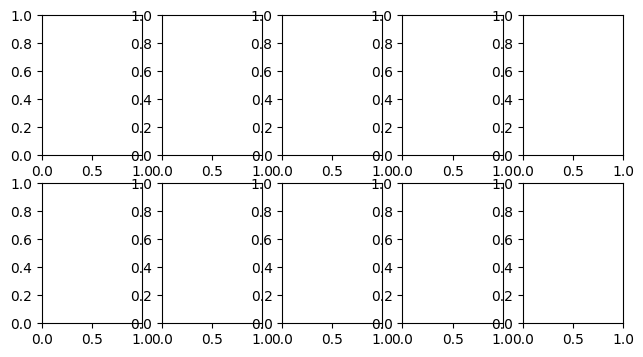

In [13]:
num_row = 2
num_col = 5
num = 10
dim = 28
length = dim * dim

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    img = new_params[i*length:(i+1)*length]
    img = img.reshape((dim, dim))
    ax.imshow(img, cmap='gray')
    ax.set_title('Class: {}'.format(i))
plt.tight_layout()
plt.show()

In [124]:
reshaped_new_params = new_params.reshape((num_classes, -1))
print(reshaped_new_params.shape, training_set.shape)
poly_scores = training_set @ reshaped_new_params.transpose()
maximised = poly_scores.argmax(axis=1)
np.equal(maximised,training_labels).sum() / len(maximised)

(10, 784) (60000, 784)


0.13753333333333334

In [103]:
reshaped_param = param.reshape((num_classes, -1))
print(reshaped_param.shape, training_set.shape)
poly_scores = training_set @ reshaped_param.transpose()
maximised = poly_scores.argmax(axis=1)
np.equal(maximised,training_labels).sum() / len(maximised)

(10, 784) (60000, 784)


0.08648333333333333

In [89]:
sample_size_2 = num_images // 300
np.random.set_state(rs.get_state())
rng = np.random.default_rng()
#param = rng.standard_normal(size=[num_classes * img_size], dtype='float64')

dir_shape = [num_directions, num_classes * img_size]
directions_noise = rng.standard_normal(size=dir_shape, dtype='float64') #+ np.ones(shape=dir_shape, dtype='float64')
directions = directions_noise # + directions
projection = np.concatenate([directions, np.expand_dims(new_params, 0)], axis=0)
# Because the feature vector is mostly sparse, we reshape our projection matrix
reshaped = projection.transpose().reshape([num_classes, img_size, -1])


sample_indices = np.random.choice(num_images, size=sample_size_2, replace=False)
samples = []
for index in sample_indices:
    samples.append((labels[index], images[index]))
    #if len(samples) == num_classes:
    #    break

sampled_labels, sampled_images = (np.array(ary) for ary in zip(*samples))
#projected = training_set[sample_indices, :] @ reshaped
projected = sampled_images @ reshaped

In [90]:
polytopes = projected.transpose([1,0,2]).reshape([-1])
polytope_dim = num_classes * proj_dim
vertex_index = np.tile(np.arange(stop=polytope_dim, dtype="i"), len(samples)) // proj_dim
polytope_index = np.arange(stop=polytope_dim * len(samples), dtype="i") // polytope_dim
dim = np.tile(np.arange(stop=proj_dim, dtype="i"), len(samples) * num_classes)

with open("./labels.json", "w") as label_file:
    json.dump(sampled_labels.tolist(), label_file)

polytope_table = pa.table({"polytope": polytope_index, "vertex": vertex_index, "dim": dim, "value": polytopes})
pq.write_table(polytope_table, "mnist_iter2.parquet")
# inputs = [{"vertices" : points.tolist()} for points in polytopes]
# print(inputs[0])
# with open("mnist.json", "wt") as out_file:
#     json.dump(inputs, out_file, indent=2)

## Studying the output of polylearn

7850


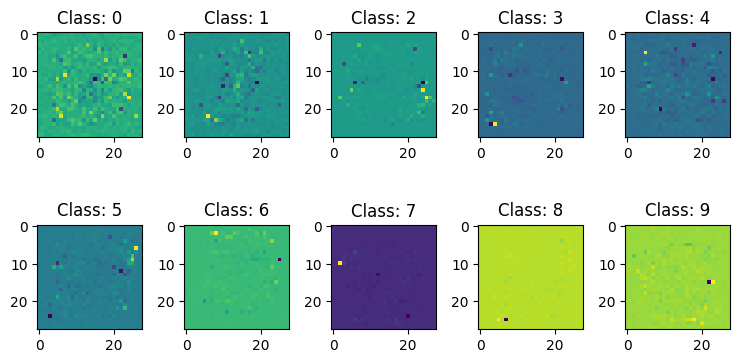

In [32]:
with open("exp13/params.txt") as params_file:
    learnt_params = np.array([json.loads(line) for line in params_file])
print(len(learnt_params[-1]))
plot_params(learnt_params[-1])

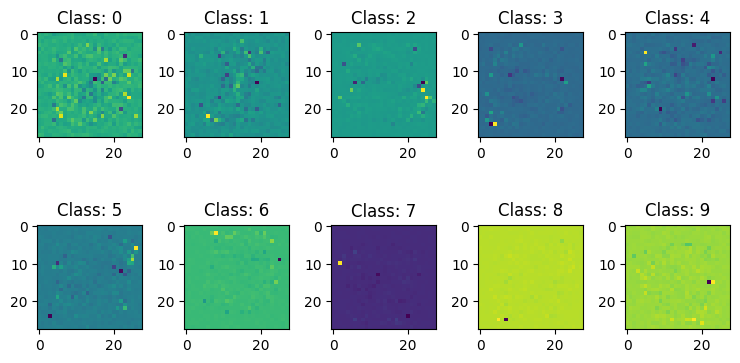

In [13]:
plot_params(learnt_params[-1])

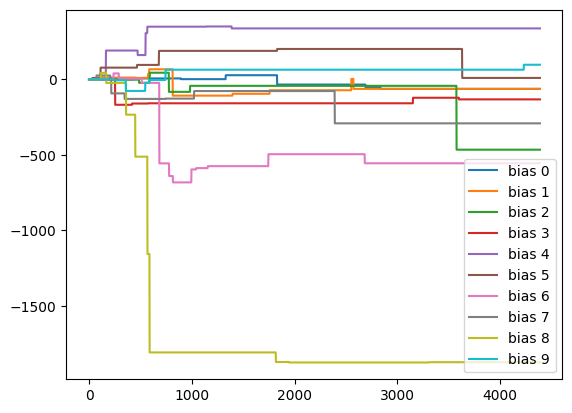

In [7]:
for i in range(num_classes):
    bias = learnt_params[:, i * (img_size + 1) + img_size]
    plt.plot(bias, label=f"bias {i}")

plt.legend(loc="lower right")


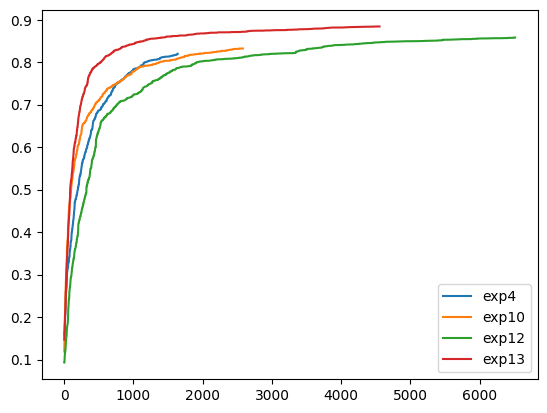

In [14]:
def plot_exp(exp_name):
    with open(f"{exp_name}/log.txt") as log_file:
        logged_scores = [float(line.split()[-1]) for line in log_file]
    plt.plot(logged_scores, label=exp_name)



#for exp_name in ["exp4", "exp7", "exp8", "exp9", "exp10", "exp12"]:
for exp_name in ["exp4", "exp10", "exp12", "exp13"]:
    plot_exp(exp_name)

plt.legend(loc="lower right")

## Test set performance

In [30]:
test_images, test_labels = mndata.load_testing()

test_set = np.array(test_images)
test_labels = np.array(test_labels)
print(len(test_labels))

def accuracy(test_params):
    reshaped_new_params = test_params.reshape((num_classes, -1))
    with_bias = np.concat([test_set, np.ones([len(test_labels), 1])], dtype="float64", axis=1)
    poly_scores = with_bias @ reshaped_new_params.transpose()
    maximised = poly_scores.argmax(axis=1)
    acc = np.equal(maximised, test_labels).sum() / len(maximised)
    return acc.item()

10000


In [36]:
accuracy(learnt_params[-1])

0.8795

In [ ]:
def plot_test(exp_name):
    test_scores = [accuracy(param) for param in learnt_params]
    plt.plot(test_scores, label=exp_name)